In [2]:
import h5py
import numpy as np

In [3]:
# here, enter your own datapath
data_dir = '/media/nas/sca/ASCAD_databases/'
model_dir = data_dir + 'model/'
csv_dir = data_dir + 'csv/'
graph_dir = data_dir + 'graph/'
pickle_dir = data_dir + 'pickle/'

In [4]:
Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

HW = np.array([bin(n).count("1") for n in range(0,256)])

### Read Traces, plaintexts, keys, masks values and initialize the labels used afterwards

In [5]:
n_samples = 10000
targeted_sbox_index = 2

f = h5py.File(data_dir + "ATMega8515_raw_traces.h5", "r")
l = f['traces'][:n_samples, :]
l = l.astype(float)
data = np.array(f['metadata'][:n_samples])
k    = data['key'][:,targeted_sbox_index]
p    = data['plaintext'][:,targeted_sbox_index]
r    = data['masks'][:,targeted_sbox_index-2]
rout = data['masks'][:,15]

id_label_withMaskRout    = Sbox[k^p]^rout
hw_label_withMaskRout    = HW[id_label_withMaskRout]
id_label_withoutMaskRout = id_label_withMaskRout^rout
hw_label_withoutMaskRout = HW[id_label_withoutMaskRout]
id_label_withMaskR       = Sbox[k^p]^r

### Compute the instantaneous mean and the instantaneous variance of the traces knowing the label **id_label_withoutMaskRout**
ie for every time smaple t, it estimates 
`mean[l[t] | Sbox[k^p]]` 
and 
`var[l[t] | Sbox[k^p]]` 

In [6]:
trace_length = l.shape[1]
mean = np.zeros([256,trace_length])
var  = np.zeros([256,trace_length])
cpt  = np.zeros(256)
i = 0

for trace in l:
    mean[id_label_withoutMaskRout[i]]  += trace
    var [id_label_withoutMaskRout[i]]  += np.square(trace)
    cpt [id_label_withoutMaskRout[i]]  += 1
    i+=1

for i in range(256):
    mean[i] = mean[i] / cpt[i]
    var[i]  = var[i]  / cpt[i] - np.square(mean[i])
    


### Compute the instantaneous mean mean2 and the instantaneous variance var2 of the traces knowing the label **id_label_withMaskRout**
ie for every time smaple t, it estimates `mean[l[t] | Sbox[k^p]^rout]` and `var[tr[t] | Sbox[k^p]^rout]` 

In [8]:
trace_length = l.shape[1]
mean2 = np.zeros([256,trace_length])
var2  = np.zeros([256,trace_length])
cpt2  = np.zeros(256)
i = 0

for trace in l:
    mean2[id_label_withMaskRout[i]]  += trace
    var2 [id_label_withMaskRout[i]]  += np.square(trace)
    cpt2 [id_label_withMaskRout[i]]  += 1
    i+=1

for i in range(256):
    mean2[i] = mean2[i] / cpt2[i]
    var2[i]  = var2[i]  / cpt2[i] - np.square(mean2[i])

### Compute the instantaneous mean _meanMaskedLin_ and the instantaneous variance _varMaskedLin_ of the traces knowing the label **id_label_withMaskR**
ie for every time smaple t, it estimates `mean[l[t] | Sbox[k^p]^r]` and `var[l[t] | Sbox[k^p]^r]` 

In [9]:
trace_length = l.shape[1]
meanMaskedLin = np.zeros([256,trace_length])
varMaskedLin  = np.zeros([256,trace_length])
cptMaskedLin  = np.zeros(256)
i = 0

for trace in l:
    meanMaskedLin[id_label_withMaskR[i]] += trace
    varMaskedLin[id_label_withMaskR[i]]  += np.square(trace)
    cptMaskedLin[id_label_withMaskR[i]]  += 1
    i+=1

for i in range(256):
    meanMaskedLin[i] = meanMaskedLin[i] / cptMaskedLin[i]
    varMaskedLin[i]  = varMaskedLin[i]  / cptMaskedLin[i] - np.square(meanMaskedLin[i])

### Compute the instantaneous mean _meanRout_ and the instantaneous variance _varRout_ of the traces knowing the label **rout**
ie for every time smaple t, it estimates `mean[l[t] | rout]` and `var[l[t] | rout]` 

In [13]:
trace_length = l.shape[1]
meanRout = np.zeros([256,trace_length])
varRout  = np.zeros([256,trace_length])
cptRout  = np.zeros(256)
i = 0

for trace in l:
    meanRout[rout[i]] += trace
    varRout [rout[i]]  += np.square(trace)
    cptRout [rout[i]]  += 1
    i+=1

for i in range(256):
    meanRout[i] = meanRout[i] / cptRout[i]
    varRout[i]  = varRout[i]  / cptRout[i] - np.square(meanRout[i])

### Compute the instantaneous mean _meanR_ and the instantaneous variance _varR_ of the traces knowing the label **r**
ie for every time smaple t, it estimates `mean[l[t] | r]` and `var[l[t] | r]` 

In [23]:
trace_length = l.shape[1]
meanR = np.zeros([256,trace_length])
varR  = np.zeros([256,trace_length])
cptMaskR  = np.zeros(256)
i = 0

for trace in l:
    meanR[r[i]] += trace
    varR [r[i]]  += np.square(trace)
    cptMaskR [r[i]]  += 1
    i+=1

for i in range(256):
    meanR[i] = meanR[i] / cptMaskR[i]
    varR[i]  = varR[i]  / cptMaskR[i] - np.square(meanR[i])

### Compute `mean [var_cond]` and `var[mean_cond]` for the conditional variances and means previously processed

In [24]:
#varL = np.var(l,0)
# for label id_label_withoutMaskRout = S[p^k]
varMean = np.var  (mean,0)
MeanVar = np.mean (var,0)
# for label id_label_withMaskRout = S[p^k] ^ rout
varMean2 = np.var  (mean2,0)
MeanVar2 = np.mean (var2,0)
# for label id_label_withoutMaskR = S[p^k] ^ r
varMeanMaskedLin = np.var  (meanMaskedLin,0)
MeanVarMaskedLin = np.mean (varMaskedLin,0)
# for label rout 'rout'
varMeanRout = np.var  (meanRout,0)
MeanVarRout = np.mean (varRout,0)
# for label r 'r'
varMeanR = np.var  (meanR,0)
MeanVarR = np.mean (varR,0)

### Plot the SNRs and generate figures

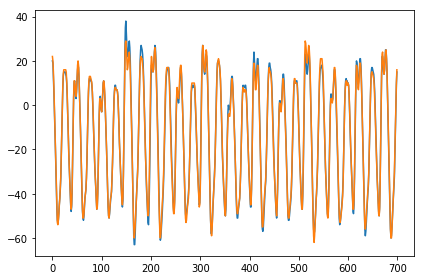

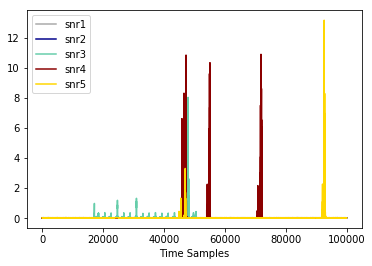

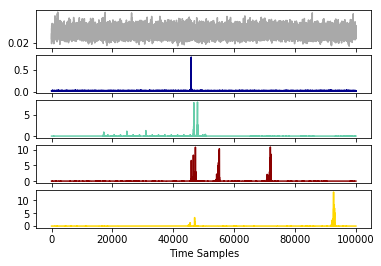

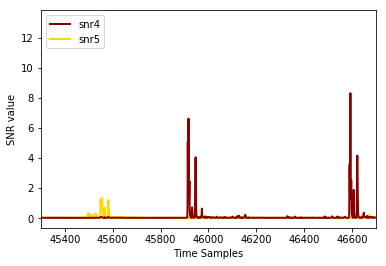

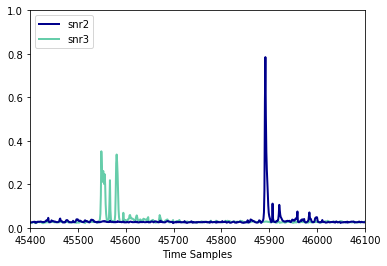

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.set_cmap('Blues')
plt.plot(l[0:2,45400:46100].transpose())
plt.tight_layout()
plt.savefig('fig_traces.pdf',format='pdf',dpi=1000) 
plt.show()


snr1, = plt.plot((varMean/MeanVar),'darkgray',label='snr1')  
snr2, = plt.plot((varMean2/MeanVar2),'darkblue',label='snr2')
snr3, = plt.plot((varMeanRout/MeanVarRout),'mediumaquamarine',label='snr3')  
snr4, = plt.plot((varMeanMaskedLin/MeanVarMaskedLin),'darkred',label='snr4') 
snr5, = plt.plot((varMeanR/MeanVarR),'gold',label='snr5') 
plt.xlabel('Time Samples')
plt.legend(handles=[snr1,snr2,snr3,snr4,snr5],loc=2)
#plt.plot(varMeanPt/MeanVarPt,'b') 
plt.savefig('fig_snr_big.pdf',format='pdf',dpi=1000) 
plt.show()
tick_spacing = 1
f, axarr = plt.subplots(5,sharex=True)
snr1, = axarr[0].plot((varMean/MeanVar),'darkgray',label='snr1')  
axarr[0].yaxis.set_major_locator(ticker.MultipleLocator(0.020))
snr2, = axarr[1].plot((varMean2/MeanVar2),'darkblue',label='snr2')  
axarr[1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
snr3, = axarr[2].plot((varMeanRout/MeanVarRout),'mediumaquamarine',label='snr3')   
axarr[2].yaxis.set_major_locator(ticker.MultipleLocator(5))
snr4, = axarr[3].plot((varMeanMaskedLin/MeanVarMaskedLin),'darkred',label='snr4')  
axarr[3].yaxis.set_major_locator(ticker.MultipleLocator(5))
snr5, = axarr[4].plot((varMeanR/MeanVarR),'gold',label='snr5',linestyle='-') 
axarr[4].yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xlabel('Time Samples')
plt.savefig('fig_snr_big_split.pdf',format='pdf',dpi=1000) 
plt.show()
snr5, = plt.plot((varMeanR/MeanVarR),'gold',label='snr5',linewidth=2.0) 
snr4, = plt.plot((varMeanMaskedLin/MeanVarMaskedLin),'darkred',label='snr4',linewidth=2.0)  
plt.xlim(45300,46700)
plt.xlabel('Time Samples')
plt.ylabel('SNR value')
plt.legend(handles=[snr4,snr5],loc=2)
plt.savefig('fig_snr_small_sboxoutputInLin.pdf',format='pdf',dpi=1000) 
plt.show()
snr3, = plt.plot((varMeanRout/MeanVarRout),color='mediumaquamarine',label='snr3',linewidth=2.0) 
snr2, = plt.plot((varMean2/MeanVar2),color='darkblue',label='snr2',linewidth=2.0)  
plt.xlim(45400,46100)
plt.ylim(0,1)
plt.xlabel('Time Samples')
plt.legend(handles=[snr2,snr3],loc=2)
plt.savefig('fig_snr_small_sboxoutput.pdf',format='pdf',dpi=1000) 
plt.show()

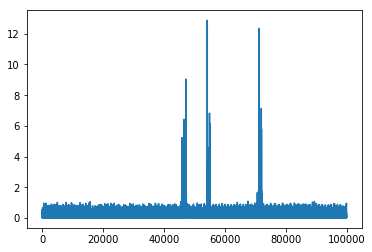

In [27]:
plt.plot(varMeanMaskedLin)
plt.show()

### Test CPA attacks on the various previous intermediate results

In [28]:
n_samples = 1000
####################################################
### Organisation des données pour Learning/testing
####################################################
# Create the data sets for training and testing

print('Start Creation Data Sets for Training and Testing')
pred_cpa_data         = np.zeros(shape=(n_samples,trace_length))
pred_cpa_unmaskedData = np.zeros(shape=(n_samples,trace_length))
pred_cpa_mask         = np.zeros(shape=(n_samples,trace_length))
pred_cpa_pt           = np.zeros(shape=(n_samples,trace_length))

pred_cpa_unit_data         = hw_label_withMaskRout[:n_samples]
pred_cpa_unit_unmaskedData = hw_label_withoutMaskRout[:n_samples]
pred_cpa_unit_mask         = HW[rout[:n_samples]]
pred_cpa_unit_pt           = HW[p[:n_samples]]
pred_cpa_data              = np.repeat(pred_cpa_unit_data,trace_length,axis=0).reshape((n_samples,trace_length))
pred_cpa_unmaskedData   = np.repeat(pred_cpa_unit_unmaskedData,trace_length,axis=0).reshape((n_samples,trace_length))
pred_cpa_mask           = np.repeat(pred_cpa_unit_mask,trace_length,axis=0).reshape((n_samples,trace_length))
pred_cpa_pt             = np.repeat(pred_cpa_unit_pt,trace_length,axis=0).reshape((n_samples,trace_length))

Start Creation Data Sets for Training and Testing


Start CPA


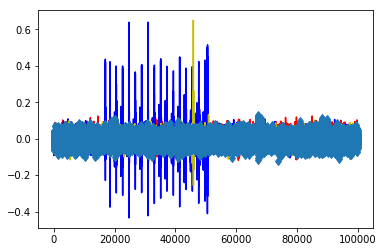

In [29]:
####################################################
### CPA
####################################################

print('Start CPA')

t_cor_data       = np.zeros(trace_length,dtype=float)
t_cor_maskedData = np.zeros(trace_length,dtype=float)
t_cor_mask       = np.zeros(trace_length,dtype=float)
t_cor_pt         = np.zeros(trace_length,dtype=float)
pred_cpa_data_transpose         = pred_cpa_data.transpose()
pred_cpa_unmaskedData_transpose = pred_cpa_unmaskedData.transpose()
pred_cpa_mask_transpose         = pred_cpa_mask.transpose()
pred_cpa_pt_transpose           = pred_cpa_pt.transpose()
dataTraces_transpose = l[:n_samples,:].transpose()
for t in range(trace_length):
    t_cor_data[t]       = np.corrcoef(pred_cpa_data_transpose[0],dataTraces_transpose[t])[1][0]
    t_cor_maskedData[t] = np.corrcoef(pred_cpa_unmaskedData_transpose[0],dataTraces_transpose[t])[1][0]
    t_cor_mask[t]       = np.corrcoef(pred_cpa_mask_transpose[0],dataTraces_transpose[t])[1][0]
    t_cor_pt[t]         = np.corrcoef(pred_cpa_pt_transpose[0],dataTraces_transpose[t])[1][0]
plt.plot(t_cor_maskedData,'r')
plt.plot(t_cor_mask,'b')
plt.plot(t_cor_data,'y')
plt.plot(t_cor_pt,'d')
plt.show()
